Logistic Regression


In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

In [3]:
len(dataset)

60000

In [4]:
test_dataset = MNIST(root='data/', train= False)
len(test_dataset)

10000

Label:  0


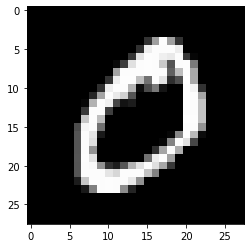

In [5]:
dataset[0]
image, label = dataset[1]
plt.imshow(image, cmap='gray')
print("Label: ", label)

In [6]:
dataset = MNIST(root= 'data/', train= True, transform=transforms.ToTensor())

In [7]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


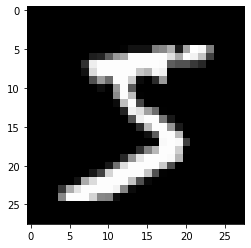

In [8]:
plt.imshow(img_tensor[0,:,:], cmap='gray')

Training and Validation Datasets
While building real-world machine learning models, it is quite common to split the dataset into three parts:

Training set - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
Validation set - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
Test set - used to compare different models or approaches and report the model's final accuracy.

In [9]:
train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds)
len(val_ds)

10000

In [10]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [11]:
input_size = 28*28
num_classes = 10

model = nn.Linear(input_size, num_classes)

In [12]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[ 0.0033, -0.0082,  0.0186,  ..., -0.0342, -0.0176, -0.0086],
        [-0.0044, -0.0190, -0.0246,  ...,  0.0293, -0.0013, -0.0146],
        [ 0.0262, -0.0056,  0.0312,  ..., -0.0101,  0.0262, -0.0305],
        ...,
        [ 0.0260, -0.0212, -0.0122,  ...,  0.0034,  0.0086,  0.0121],
        [-0.0315,  0.0251, -0.0053,  ...,  0.0301, -0.0138, -0.0293],
        [-0.0004,  0.0220, -0.0270,  ...,  0.0116,  0.0109,  0.0001]],
       requires_grad=True)

In [13]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([ 0.0157, -0.0144, -0.0291,  0.0121, -0.0311,  0.0032, -0.0351,  0.0273,
        -0.0170,  0.0201], requires_grad=True)

In [14]:
'''for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break
'''

'for images, labels in train_loader:\n    print(labels)\n    print(images.shape)\n    outputs = model(images)\n    print(outputs)\n    break\n'

The code above leads to an error because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. We'll use the .reshape method of a tensor, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data. To include this additional functionality within our model, we need to define a custom model by extending the nn.Module class from PyTorch.

In [16]:
images.shape

NameError: name 'images' is not defined

In [ ]:
images.reshape(128,784).shape

In [17]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

nside the __init__ constructor method, we instantiate the weights and biases using nn.Linear. And inside the forward method, which is invoked when we pass a batch of inputs to the model, we flatten the input tensor and pass it into self.linear.

xb.reshape(-1, 28*28) indicates to PyTorch that we want a view of the xb tensor with two dimensions. The length along the 2nd dimension is 28*28 (i.e., 784). One argument to .reshape can be set to -1 (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has .weight and .bias attributes (as they are now inside the .linear attribute), but it does have a .parameters method that returns a list containing the weights and bias.

In [18]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [19]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0074, -0.0145, -0.0062,  ..., -0.0067,  0.0238,  0.0211],
         [-0.0252, -0.0067,  0.0225,  ...,  0.0220,  0.0284,  0.0005],
         [-0.0299,  0.0033,  0.0152,  ...,  0.0084,  0.0080, -0.0315],
         ...,
         [-0.0059,  0.0185,  0.0026,  ..., -0.0297, -0.0008, -0.0086],
         [-0.0103,  0.0213, -0.0237,  ...,  0.0009,  0.0029, -0.0257],
         [-0.0330, -0.0329,  0.0348,  ..., -0.0074, -0.0318, -0.0318]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0161, -0.0248,  0.0124, -0.0089,  0.0117, -0.0133,  0.0339, -0.0231,
         -0.0111, -0.0274], requires_grad=True)]

In [20]:
#we can now try to use the custom model
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break
print("Output shape:",outputs.shape)
print('Sample outputs:', outputs[:2].data)

torch.Size([128, 1, 28, 28])
Output shape: torch.Size([128, 10])
Sample outputs: tensor([[-0.1425, -0.0712,  0.1231,  0.1366,  0.1603, -0.2668,  0.0613, -0.1372,
          0.2012, -0.0912],
        [ 0.0811,  0.0854,  0.3209,  0.1230,  0.2138, -0.1072, -0.1477, -0.3438,
          0.1994, -0.0307]])


In [21]:
outputs[:2]

tensor([[-0.1425, -0.0712,  0.1231,  0.1366,  0.1603, -0.2668,  0.0613, -0.1372,
          0.2012, -0.0912],
        [ 0.0811,  0.0854,  0.3209,  0.1230,  0.2138, -0.1072, -0.1477, -0.3438,
          0.1994, -0.0307]], grad_fn=<SliceBackward0>)

In [22]:
probs = F.softmax(outputs, dim=1)

print("Sample probabilities:", probs[:2].data)
print('Sum:', torch.sum(probs[0].data))

Sample probabilities: tensor([[0.0860, 0.0923, 0.1121, 0.1137, 0.1164, 0.0759, 0.1054, 0.0864, 0.1212,
         0.0905],
        [0.1025, 0.1029, 0.1303, 0.1069, 0.1170, 0.0849, 0.0815, 0.0670, 0.1154,
         0.0916]])
Sum: tensor(1.0000)


Above is the probabilities of each value 0-9 being the correct answer based on the model

In [24]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([8, 2, 5, 3, 2, 2, 3, 5, 8, 7, 3, 2, 3, 5, 8, 2, 4, 2, 4, 3, 2, 2, 2, 3,
        8, 6, 8, 4, 2, 8, 3, 2, 0, 2, 8, 4, 2, 3, 2, 5, 2, 8, 8, 3, 2, 8, 3, 4,
        8, 6, 8, 2, 2, 2, 8, 3, 5, 4, 3, 2, 8, 4, 6, 4, 2, 2, 8, 2, 4, 4, 3, 4,
        6, 4, 2, 3, 8, 6, 3, 2, 7, 8, 4, 8, 4, 4, 4, 4, 3, 2, 8, 8, 5, 5, 4, 4,
        4, 4, 8, 2, 2, 8, 3, 2, 2, 2, 4, 8, 2, 8, 3, 8, 8, 8, 4, 2, 3, 8, 2, 8,
        2, 2, 8, 2, 8, 8, 4, 8])
tensor([0.1212, 0.1303, 0.1330, 0.1355, 0.1391, 0.1272, 0.1187, 0.1202, 0.1318,
        0.1207, 0.1412, 0.1496, 0.1303, 0.1290, 0.1303, 0.1342, 0.1174, 0.1623,
        0.1253, 0.1321, 0.1275, 0.1265, 0.1368, 0.1537, 0.1279, 0.1325, 0.1251,
        0.1204, 0.1346, 0.1249, 0.1315, 0.1263, 0.1131, 0.1501, 0.1263, 0.1253,
        0.1535, 0.1523, 0.1386, 0.1185, 0.1464, 0.1259, 0.1454, 0.1234, 0.1526,
        0.1257, 0.1253, 0.1282, 0.1164, 0.1353, 0.1316, 0.1668, 0.1186, 0.1238,
        0.1226, 0.1225, 0.1270, 0.1304, 0.1628, 0.1504, 0.1145, 0.1172, 0.1237,
       

In [25]:
labels

tensor([7, 1, 2, 2, 2, 7, 5, 0, 7, 8, 2, 1, 0, 0, 7, 3, 9, 3, 7, 8, 7, 9, 1, 2,
        3, 0, 8, 9, 8, 4, 1, 3, 5, 1, 9, 0, 3, 3, 0, 2, 8, 8, 9, 4, 3, 7, 8, 2,
        9, 0, 3, 3, 9, 1, 9, 4, 5, 6, 2, 1, 7, 9, 0, 0, 9, 1, 3, 3, 4, 1, 6, 0,
        2, 7, 1, 3, 5, 0, 3, 3, 0, 8, 6, 4, 2, 4, 9, 6, 3, 2, 7, 1, 9, 0, 7, 7,
        5, 5, 8, 9, 0, 4, 3, 8, 0, 1, 7, 6, 2, 1, 6, 7, 0, 0, 7, 3, 2, 8, 1, 6,
        7, 3, 9, 7, 5, 0, 7, 3])

In [26]:
torch.sum(torch.eq(preds,labels))

tensor(16)

In [27]:
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(torch.eq(preds, labels)).item() / len(preds))
    

In [28]:
accuracy(outputs, labels)

tensor(0.1250)

In [29]:
probs

tensor([[0.0860, 0.0923, 0.1121,  ..., 0.0864, 0.1212, 0.0905],
        [0.1025, 0.1029, 0.1303,  ..., 0.0670, 0.1154, 0.0916],
        [0.0822, 0.1015, 0.0833,  ..., 0.0818, 0.1014, 0.0985],
        ...,
        [0.1094, 0.0811, 0.0902,  ..., 0.1105, 0.1135, 0.0921],
        [0.1157, 0.0880, 0.1014,  ..., 0.0900, 0.0988, 0.0902],
        [0.0828, 0.0686, 0.1386,  ..., 0.1113, 0.1679, 0.0596]],
       grad_fn=<SoftmaxBackward0>)

For these reasons, accuracy is often used as an evaluation metric for classification, but not as a loss function. A commonly used loss function for classification problems is the cross-entropy, which has the following formula:

cross-entropy

While it looks complicated, it's actually quite simple:

For each output row, pick the predicted probability for the correct label. E.g., if the predicted probabilities for an image are [0.1, 0.3, 0.2, ...] and the correct label is 1, we pick the corresponding element 0.3 and ignore the rest.

Then, take the logarithm of the picked probability. If the probability is high, i.e., close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.



Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.
Unlike accuracy, cross-entropy is a continuous and differentiable function. It also provides useful feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). These two factors make cross-entropy a better choice for the loss function.

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the torch.nn.functional package. Moreover, it also performs softmax internally, so we can directly pass in the model's outputs without converting them into probabilities.

In [30]:
loss_fn = F.cross_entropy

In [31]:
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.2854, grad_fn=<NllLossBackward0>)


We know that cross-entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples. Therefore, one way to interpret the resulting number e.g. 2.23 is look at e^-2.23 which is around 0.1 as the predicted probability of the correct label, on average. The lower the loss, The better the model.

Training the model
Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem.

We'll include the problem-independent parts within a function called fit, which will be used to train the model. The problem-specific parts will be implemented by adding new methods to the nn.Module class.

In [32]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = []
    
    for epoch in range(epochs):
        #Training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        #Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [33]:
l1 = [1,2,3,4]

In [34]:
l2 = [x*2 for x in l1]
l2

[2, 4, 6, 8]

In [35]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [36]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [37]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.3056113719940186, 'val_acc': 0.1126384511590004}

In [38]:
history1 = fit(5, .001, model, train_loader, val_loader)


Epoch [0], val_loss: 1.9394, val_acc: 0.6230
Epoch [1], val_loss: 1.6705, val_acc: 0.7351
Epoch [2], val_loss: 1.4689, val_acc: 0.7683
Epoch [3], val_loss: 1.3163, val_acc: 0.7900
Epoch [4], val_loss: 1.1987, val_acc: 0.8028


In [39]:
history2 = fit(5, .001, model, train_loader, val_loader)


Epoch [0], val_loss: 1.1063, val_acc: 0.8119
Epoch [1], val_loss: 1.0321, val_acc: 0.8189
Epoch [2], val_loss: 0.9714, val_acc: 0.8251
Epoch [3], val_loss: 0.9208, val_acc: 0.8310
Epoch [4], val_loss: 0.8781, val_acc: 0.8353


In [40]:
history3 = fit(5, .001, model, train_loader, val_loader)


Epoch [0], val_loss: 0.8415, val_acc: 0.8385
Epoch [1], val_loss: 0.8099, val_acc: 0.8423
Epoch [2], val_loss: 0.7821, val_acc: 0.8456
Epoch [3], val_loss: 0.7576, val_acc: 0.8477
Epoch [4], val_loss: 0.7358, val_acc: 0.8495


In [41]:
history4 = fit(5, .001, model, train_loader, val_loader)


Epoch [0], val_loss: 0.7162, val_acc: 0.8521
Epoch [1], val_loss: 0.6985, val_acc: 0.8541
Epoch [2], val_loss: 0.6825, val_acc: 0.8557
Epoch [3], val_loss: 0.6679, val_acc: 0.8569
Epoch [4], val_loss: 0.6545, val_acc: 0.8582


Text(0.5, 1.0, 'Accurcacy of number recognition based on epochs')

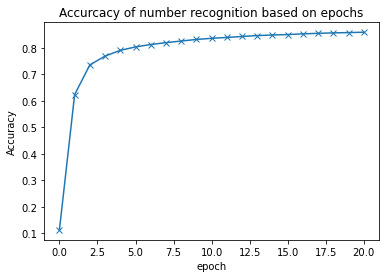

In [42]:
history = [result0]+history1+history2+history3+history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accurcacy of number recognition based on epochs')

Testing model on individual values

In [43]:
test_dataset = MNIST(root = 'data/', train= False, transform=transforms.ToTensor())

Label: 7


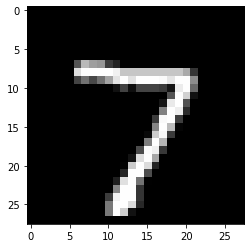

In [44]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label)

In [45]:
def predictImg(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, pred = torch.max(yb, dim=1)
    return pred[0].item()

Label: 6 , Predicted: 6


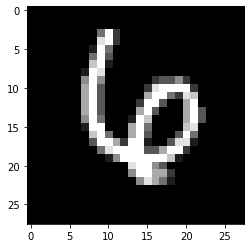

In [46]:
img, label = test_dataset[22]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predictImg(img, model))

Label: 1 , Predicted: 1


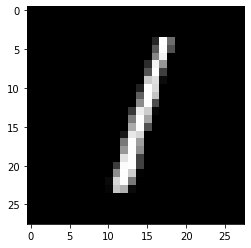

In [47]:
img, label = test_dataset[2]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predictImg(img, model))

Label: 8 , Predicted: 8


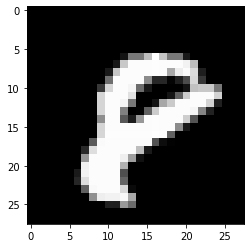

In [48]:
img, label = test_dataset[242]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predictImg(img, model))

Label: 2 , Predicted: 8


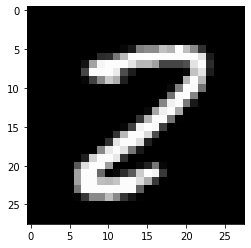

In [49]:

img, label = test_dataset[2*222]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predictImg(img, model))

In [50]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.639904797077179, 'val_acc': 0.8599609136581421}

Saving model

In [51]:
torch.save(model.state_dict(), 'mnist-logistic.pth')


Model values

In [52]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0036, -0.0248,  0.0268,  ...,  0.0246,  0.0225,  0.0355],
                      [ 0.0074, -0.0348, -0.0010,  ..., -0.0329,  0.0171,  0.0246],
                      [ 0.0036,  0.0127,  0.0273,  ..., -0.0031, -0.0310, -0.0247],
                      ...,
                      [ 0.0334, -0.0242, -0.0061,  ..., -0.0298,  0.0040, -0.0280],
                      [ 0.0329, -0.0056, -0.0168,  ...,  0.0001,  0.0013,  0.0324],
                      [-0.0302,  0.0137, -0.0351,  ..., -0.0103,  0.0306, -0.0272]])),
             ('linear.bias',
              tensor([-0.0590,  0.0804, -0.0050, -0.0040,  0.0067,  0.0411, -0.0088,  0.0548,
                      -0.1155,  0.0045]))])